# parPE steadystate example model

In [1]:
import amici
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from importlib import reload

# set paths
parpe_source_root = os.path.abspath('../../../')
parpe_build_root = os.path.join(parpe_source_root, 'build') 

model_source_dir = f'{parpe_build_root}/amici/examples/steadystate/steadystate_scaled-prefix/src/steadystate_scaled/model_steadystate_scaled'
example_binary_dir = f'{parpe_build_root}/amici/examples/steadystate/'
example_data_dir = f'{parpe_build_root}/amici/examples/steadystate/steadystate_scaled-prefix/src/steadystate_scaled'
optimizationOptionsPy = f'{parpe_source_root}/misc/optimizationOptions.py'

# load parpe module from source tree
sys.path.insert(0, os.path.join(parpe_source_root, 'python'))
import parpe

In [2]:
# rebuild example
!cd {parpe_build_root} && make

-- Found Git: /usr/bin/git (found version "2.17.1") 
-- Building version parPE-v0.1.8-100-g300a-dirty
[  0%] Built target get_version
[  8%] Built target parpecommon
[ 11%] Built target parpeloadbalancer
[ 21%] Built target parpeoptimization
[ 31%] Built target parpeamici
[ 32%] Built target parpe
[ 37%] Built target unittests_common
[ 42%] Built target unittests_optimization_ipopt
[ 51%] Built target unittests_optimization
[ 55%] Built target unittests_optimization_ceres
[ 58%] Built target unittests_loadbalancer
[ 61%] Built target example_loadbalancer
[ 70%] Built target steadystate_scaled
[ 73%] Built target example_steadystate
[ 78%] Built target example_steadystate_parallel
[ 82%] Built target example_steadystate_multi
[ 85%] Built target example_steadystate_multi_simulator
[ 90%] Built target test_steadystate
[100%] Built target unittests_amici


## Test simulation

In [3]:
# load model
sys.path.insert(0, model_source_dir)
import model_steadystate_scaled as modelModule

model = modelModule.getModel()
model.setTimepoints(amici.DoubleVector(np.logspace(-5, 1, 20))) 
solver = model.getSolver()
rdata = amici.runAmiciSimulation(model, solver)

default_parameters = np.array(model.getParameters())
print(default_parameters)
print(rdata)

[1.  0.5 0.4 2.  0.1 2.  3.  0.2]
{'ptr': <amici.amici.ReturnDataPtr; proxy of <Swig Object of type 'std::unique_ptr< amici::ReturnData > *' at 0x7fa1281be8a0> >, 't': array([1.00000000e-05, 2.06913808e-05, 4.28133240e-05, 8.85866790e-05,
       1.83298071e-04, 3.79269019e-04, 7.84759970e-04, 1.62377674e-03,
       3.35981829e-03, 6.95192796e-03, 1.43844989e-02, 2.97635144e-02,
       6.15848211e-02, 1.27427499e-01, 2.63665090e-01, 5.45559478e-01,
       1.12883789e+00, 2.33572147e+00, 4.83293024e+00, 1.00000000e+01]), 'x': array([[0.1000178 , 0.4000123 , 0.6999792 ],
       [0.10003683, 0.40002545, 0.69995696],
       [0.1000762 , 0.40005266, 0.69991096],
       [0.10015767, 0.40010894, 0.69981577],
       [0.1003262 , 0.40022538, 0.69961885],
       [0.10067479, 0.40046616, 0.6992116 ],
       [0.10139555, 0.4009638 , 0.69836975],
       [0.10288464, 0.40199105, 0.69663131],
       [0.10595616, 0.4041061 , 0.69304903],
       [0.11227026, 0.40843807, 0.6856998 ],
       [0.12515789, 

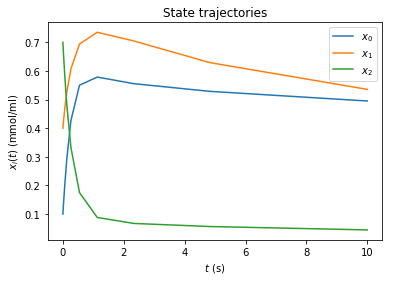

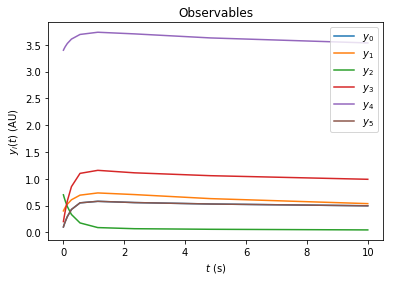

In [4]:
from amici.plotting import plotStateTrajectories
from amici.plotting import plotObservableTrajectories

plotStateTrajectories(rdata)
plotObservableTrajectories(rdata)

## Create in silico experimental data for parameter estimation

- Simulate time-course for four different conditions
- Add gaussian noise according to selected sigma parameter
- Mimic 2 experimental batches: odd-numbered condition indices and even-numbered conditions have different offset parameter

In [5]:
# enable derivate checker
input_file = f'{example_data_dir}/example_data.h5'
#!{optimizationOptionsPy} {input_file} -s ipopt/derivative_test first-order
#!{optimizationOptionsPy} {input_file} -s ipopt/derivative_test_print_all yes
!{optimizationOptionsPy} {input_file} -s numStarts 2
!{optimizationOptionsPy} {input_file} -s hierarchicalOptimization 0
!{optimizationOptionsPy} {input_file}


                hierarchicalOptimization            0
                               numStarts            2
                               optimizer            0
                       retryOptimization            0
                ceres/max_num_iterations          100
                         fmincon/GradObj        b'on'
                     fmincon/MaxFunEvals   10000000.0
                         fmincon/MaxIter          100
                          fmincon/TolFun            0
                            fmincon/TolX        1e-08
                       fmincon/algorithm b'interior-point'
                         fmincon/display      b'iter'
                   ipopt/acceptable_iter            1
         ipopt/acceptable_obj_change_tol        1e-05
                    ipopt/acceptable_tol        1e-05
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                          ipopt/max_iter          100
                  

## Gradient check

In [6]:
for i in range(3):
    !PARPE_NO_DEBUG=1 {example_binary_dir}/example_steadystate_multi -t gradient_check -o deletemegc/ {input_file}


[2019-01-13 18:43:29] [ERR] [-1/]     0 g:  9.47146e+11  fd_c:            0  Δ/fd_c: 9.471465e+16  f:  4.31997e+22
[2019-01-13 18:43:29] [ERR] [-1/]     1 g:   -1.869e+08  fd_c:            0  Δ/fd_c: -1.869002e+13  f:  4.31997e+22
[2019-01-13 18:43:29] [ERR] [-1/]     2 g: -1.99512e+12  fd_c:            0  Δ/fd_c: -1.995123e+17  f:  4.31997e+22
[2019-01-13 18:43:29] [ERR] [-1/]     3 g:  3.26599e+10  fd_c:            0  Δ/fd_c: 3.265991e+15  f:  4.31997e+22
[2019-01-13 18:43:29] [ERR] [-1/]     4 g:  2.74486e+11  fd_c:            0  Δ/fd_c: 2.744862e+16  f:  4.31997e+22
[2019-01-13 18:43:29] [ERR] [-1/]     5 g:  1.49364e+06  fd_c:            0  Δ/fd_c: 1.493640e+11  f:  4.31997e+22
[2019-01-13 18:43:29] [ERR] [-1/]     6 g:  1.82973e+13  fd_c:            0  Δ/fd_c: 1.829732e+18  f:  4.31997e+22
[2019-01-13 18:43:30] [ERR] [-1/]     7 g:      28.9491  fd_c:            0  Δ/fd_c: 2.894908e+06  f:  4.31997e+22
[2019-01-13 18:43:30] [ERR] [-1/]     8 g:  3.28722e+12  fd_c:            0  Δ

## Optimize

In [7]:
!pwd
!(cd {parpe_build_root} && exec make -j12)
!rm -rf deleteme
!PARPE_NO_DEBUG=1 {example_binary_dir}/example_steadystate_multi -o deleteme/ {example_data_dir}/example_data.h5


/home/dweindl/src/parPE/amici/examples/steadystate
-- Found Git: /usr/bin/git (found version "2.17.1") 
-- Building version parPE-v0.1.8-100-g300a-dirty
[  8%] Built target parpecommon
[  8%] Built target get_version
[ 11%] Built target parpeloadbalancer
[ 16%] Built target unittests_common
[ 26%] Built target parpeoptimization
[ 28%] Built target example_loadbalancer
[ 32%] Built target unittests_optimization_ipopt
[ 35%] Built target unittests_loadbalancer
[ 46%] Built target parpeamici
[ 55%] Built target unittests_optimization
[ 60%] Built target unittests_optimization_ceres
[ 69%] Built target steadystate_scaled
[ 70%] Built target parpe
[ 73%] Built target example_steadystate
[ 83%] Built target unittests_amici
[ 86%] Built target example_steadystate_multi_simulator
[ 89%] Built target example_steadystate_multi
[ 94%] Built target example_steadystate_parallel
[100%] Built target test_steadystate
[2019-01-13 18:43:31] [INF] [-1/] Reading random initial theta 0 from /optimizationOp

[2019-01-13 18:43:33] [INF] [-1/] [o0i21] iter: 21 cost: -361.874 time_iter: wall: 0.0804042s cpu: 0.0532326s time_optim: wall: 2.0112s cpu: 1.31287s
  21 -3.6187401e+02 0.00e+00 1.23e+01  -4.0 6.34e-02    -  1.00e+00 1.00e+00f  1
[2019-01-13 18:43:33] [INF] [-1/] [o0i22] iter: 22 cost: -362.143 time_iter: wall: 0.0970699s cpu: 0.0639121s time_optim: wall: 2.10827s cpu: 1.37678s
  22 -3.6214258e+02 0.00e+00 4.36e+00  -5.5 1.28e-01    -  1.00e+00 2.50e-01f  3
[2019-01-13 18:43:34] [INF] [-1/] [o0i23] iter: 23 cost: -362.57 time_iter: wall: 0.097849s cpu: 0.0627882s time_optim: wall: 2.20612s cpu: 1.43957s
  23 -3.6257011e+02 0.00e+00 3.40e+00  -6.7 4.36e-02    -  1.00e+00 5.00e-01f  2
[2019-01-13 18:43:34] [INF] [-1/] [o0i24] iter: 24 cost: -362.684 time_iter: wall: 0.0911298s cpu: 0.0601155s time_optim: wall: 2.29725s cpu: 1.49968s
  24 -3.6268421e+02 0.00e+00 5.85e+00  -8.4 2.21e-02    -  1.00e+00 1.00e+00f  1
[2019-01-13 18:43:34] [INF] [-1/] [o0i25] iter: 25 cost: -362.851 time_iter

[2019-01-13 18:43:37] [INF] [-1/] [o0i55] iter: 55 cost: -367.442 time_iter: wall: 0.11857s cpu: 0.0808688s time_optim: wall: 5.59648s cpu: 3.70259s
  55 -3.6744154e+02 0.00e+00 4.38e-01 -11.0 1.47e-01    -  1.00e+00 3.12e-02f  6
[2019-01-13 18:43:37] [INF] [-1/] [o0i56] iter: 56 cost: -367.442 time_iter: wall: 0.124835s cpu: 0.0846183s time_optim: wall: 5.72131s cpu: 3.78721s
  56 -3.6744167e+02 0.00e+00 3.40e-01 -11.0 3.26e-01    -  1.00e+00 7.81e-03f  8
[2019-01-13 18:43:37] [INF] [-1/] [o0i57] iter: 57 cost: -367.442 time_iter: wall: 0.119336s cpu: 0.0806562s time_optim: wall: 5.84065s cpu: 3.86786s
  57 -3.6744189e+02 0.00e+00 2.94e-01 -11.0 1.19e-01    -  1.00e+00 1.56e-02f  7
[2019-01-13 18:43:37] [INF] [-1/] [o0i58] iter: 58 cost: -367.442 time_iter: wall: 0.0811739s cpu: 0.0534344s time_optim: wall: 5.92182s cpu: 3.9213s
  58 -3.6744232e+02 0.00e+00 6.19e-01 -11.0 6.70e-03    -  1.00e+00 1.00e+00f  1
[2019-01-13 18:43:37] [INF] [-1/] [o0i59] iter: 59 cost: -367.443 time_iter: 

Total number of variables............................:        9
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        9
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

[2019-01-13 18:43:41] [INF] [-1/] [o1i0] iter: 0 cost: -254.735 time_iter: wall: 0.0805622s cpu: 0.0540027s time_optim: wall: 0.0805625s cpu: 0.0540027s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -2.5473523e+02 0.00e+00 1.00e+02   0.0 0.00e+00    -  0.00e+00 0.00e+00   0
[2019-01-13 18:43:41] [INF] [-1/] [o1i1] iter: 1 cost: 1973.05 time_iter: wall: 0.0870244s cpu: 0.0578686s t

[2019-01-13 18:43:44] [INF] [-1/] [o1i31] iter: 31 cost: -364.884 time_iter: wall: 0.113555s cpu: 0.0757959s time_optim: wall: 2.89625s cpu: 1.86772s
  31 -3.6488409e+02 0.00e+00 1.80e+01 -11.0 9.08e-01    -  1.00e+00 1.25e-01f  4
[2019-01-13 18:43:44] [INF] [-1/] [o1i32] iter: 32 cost: -365.533 time_iter: wall: 0.125569s cpu: 0.0830573s time_optim: wall: 3.02182s cpu: 1.95078s
  32 -3.6553264e+02 0.00e+00 1.79e+01 -11.0 2.60e-01    -  1.00e+00 2.50e-01f  3
[2019-01-13 18:43:44] [INF] [-1/] [o1i33] iter: 33 cost: -365.984 time_iter: wall: 0.145262s cpu: 0.0968748s time_optim: wall: 3.16709s cpu: 2.04766s
  33 -3.6598350e+02 0.00e+00 2.08e+01 -11.0 5.12e-01    -  1.00e+00 2.50e-01f  3
[2019-01-13 18:43:44] [INF] [-1/] [o1i34] iter: 34 cost: -365.996 time_iter: wall: 0.128565s cpu: 0.0849185s time_optim: wall: 3.29565s cpu: 2.13257s
  34 -3.6599564e+02 0.00e+00 4.44e+00 -11.0 1.04e+00    -  1.00e+00 6.25e-02f  5
[2019-01-13 18:43:44] [INF] [-1/] [o1i35] iter: 35 cost: -366.354 time_iter:

[2019-01-13 18:43:47] [INF] [-1/] [o1i65] iter: 65 cost: -367.443 time_iter: wall: 0.127073s cpu: 0.0839953s time_optim: wall: 6.8133s cpu: 4.45917s
  65 -3.6744344e+02 0.00e+00 1.83e-02 -11.0 1.55e-03    -  1.00e+00 3.12e-02f  6
[2019-01-13 18:43:48] [INF] [-1/] [o1i66] iter: 66 cost: -367.443 time_iter: wall: 0.117272s cpu: 0.0789774s time_optim: wall: 6.93057s cpu: 4.53815s
  66 -3.6744344e+02 0.00e+00 2.27e-02 -11.0 7.31e-04    -  1.00e+00 1.25e-01f  4
[2019-01-13 18:43:48] [INF] [-1/] [o1i67] iter: 67 cost: -367.443 time_iter: wall: 0.113577s cpu: 0.0757993s time_optim: wall: 7.04415s cpu: 4.61395s
  67 -3.6744344e+02 0.00e+00 3.15e-03 -11.0 1.97e-03    -  1.00e+00 2.50e-01f  3
[2019-01-13 18:43:48] [INF] [-1/] [o1i68] iter: 68 cost: -367.443 time_iter: wall: 0.11589s cpu: 0.0747461s time_optim: wall: 7.16004s cpu: 4.68869s
  68 -3.6744344e+02 0.00e+00 2.68e-03 -11.0 2.31e-03    -  1.00e+00 6.25e-02f  5
[2019-01-13 18:43:48] [INF] [-1/] [o1i69] iter: 69 cost: -367.443 time_iter: w

(89, 1) (89, 1)
(89, 1) (89, 2)


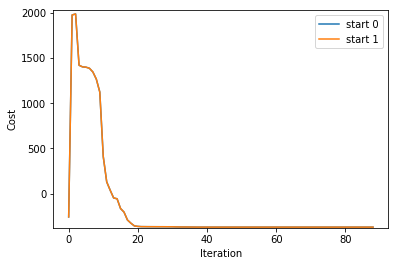

In [6]:
filename = 'deleteme/_rank-0001.h5'
trajectories = parpe.getCostTrajectories(filename)
#print(repr(trajectories))
parpe.plotting.plotCostTrajectory(trajectories, log=False);

## Compare results

In [14]:
def compareResults(filename):
    with h5py.File(filename, 'r') as f:
        pscale = f['/inputData/amiciOptions/pscale'][:]
        true_parameters = f['/inputData/parameters/true_parameters'][:]
        expectedNllh = -f['/inputData/parameters/true_llh'][:]
        final_parameters = f['/multistarts/0/finalParameters'][:]
        exit_status = f['/multistarts/0/exitStatus'][:]
        final_cost = f['/multistarts/0/finalCost'][:]

    for i, p in enumerate(pscale):
        if p == 2:
            final_parameters[i] = np.power(10, final_parameters[i])

    print("#  __Exp___ __Act___ __Err___ _RelErr___")
    for i in range(len(true_parameters)):
        error = final_parameters[i]-true_parameters[i]
        rel_error = error / true_parameters[i]
        print('%d: %6f %6f %6f %6f' % (i, true_parameters[i], 
                                       final_parameters[i], 
                                       error,rel_error))
    print('Status: %d' % exit_status)
    print('Cost: %f (expected: %f)' % (final_cost, expectedNllh))

In [17]:
compareResults('deleteme/_rank-0001.h5')

#  __Exp___ __Act___ __Err___ _RelErr___
0: 1.000000 0.946404 -0.053596 -0.053596
1: 0.500000 0.437507 -0.062493 -0.124986
2: 0.400000 0.465838 0.065838 0.164594
3: 2.000000 1.855323 -0.144677 -0.072339
4: 0.100000 0.065731 -0.034269 -0.342695
5: 2.000000 1.984290 -0.015710 -0.007855
6: 3.000000 3.032268 0.032268 0.010756
7: 0.200000 0.186232 -0.013768 -0.068838
8: 4.000000 4.021128 0.021128 0.005282
Status: 4
Cost: -367.443443 (expected: -0.000000)


In [11]:
# Simulate with optimal parameters, save results
!rm sim.h5
!{example_binary_dir}/example_steadystate_multi_simulator deleteme/_rank-0001.h5 / sim.h5 / --at-optimum

Running for start 0
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
Running for start 1
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma


In [12]:
# Load simulated outputs
with h5py.File('deleteme/_rank-0001.h5', 'r') as f:
    timepoints = f['/inputData/amiciOptions/ts'][:]

with h5py.File('sim.h5', 'r') as f:
    ysim = f['/multistarts/0/ySim'][:]
    ymes = f['/multistarts/0/yMes'][:]
    
print(ysim.shape)
print(ymes.shape)

(4, 20, 6)
(4, 20, 6)


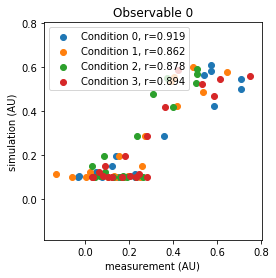

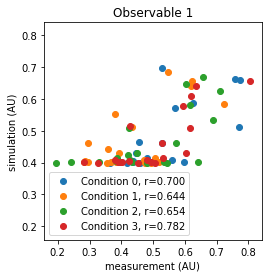

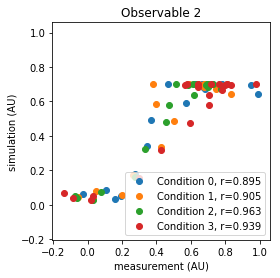

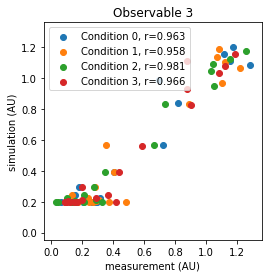

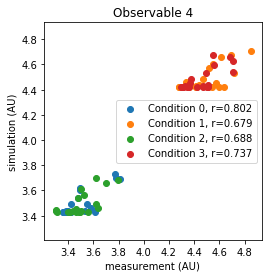

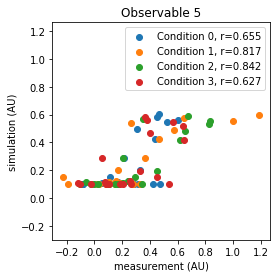

In [13]:
parpe.plotting.plotCorrelations(ymes, ysim)

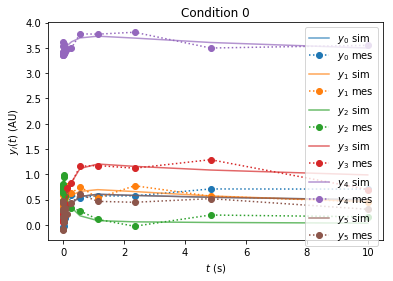

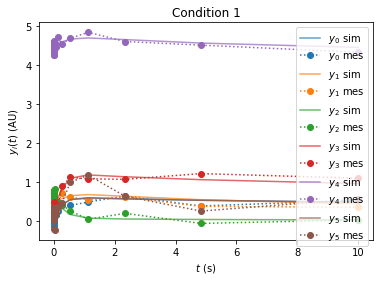

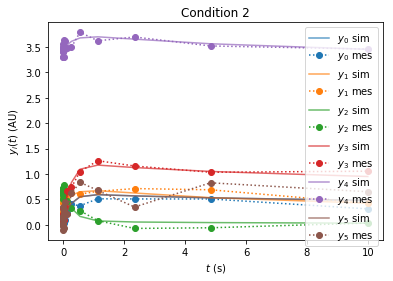

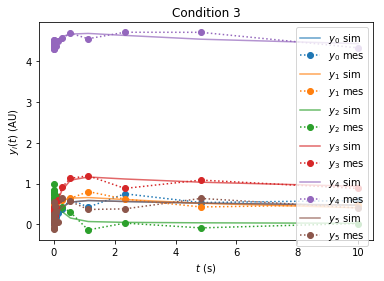

In [14]:
parpe.plotting.plotTrajectoryFits(ymes, ysim, timepoints)

## Hierarchical optimization

In [3]:
hdf5_input_file_hierarchical = f'{example_data_dir}/example_data.h5'
hdf5_pe_output_file_hierarchical = 'deletemehierarchical/_rank00000.h5'
!{optimizationOptionsPy} {hdf5_input_file_hierarchical} -s hierarchicalOptimization 1
!{optimizationOptionsPy} {hdf5_input_file_hierarchical} -s numStarts 1
!{optimizationOptionsPy} {hdf5_input_file_hierarchical} -s ipopt/max_iter 100
!{optimizationOptionsPy} {hdf5_input_file_hierarchical} -s ipopt/acceptable_obj_change_tol 1e-5
!{optimizationOptionsPy} {hdf5_input_file_hierarchical} -s ipopt/acceptable_tol 1e-5
!{optimizationOptionsPy} {hdf5_input_file_hierarchical} -s retryOptimization 0
!{optimizationOptionsPy} {hdf5_input_file_hierarchical}


                hierarchicalOptimization            1
                               numStarts            1
                               optimizer            0
                       retryOptimization            0
                ceres/max_num_iterations          100
                         fmincon/GradObj        b'on'
                     fmincon/MaxFunEvals   10000000.0
                         fmincon/MaxIter          100
                          fmincon/TolFun            0
                            fmincon/TolX        1e-08
                       fmincon/algorithm b'interior-point'
                         fmincon/display      b'iter'
                   ipopt/acceptable_iter            1
         ipopt/acceptable_obj_change_tol        1e-05
                    ipopt/acceptable_tol        1e-05
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                          ipopt/max_iter          100
                  

In [16]:
# gradient check 
!PARPE_NO_DEBUG=1 {example_binary_dir}/example_steadystate_multi -t gradient_check -o deletemegc/ {hdf5_input_file_hierarchical}


HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
[2019-01-13 18:44:07] [WRN] [-1/] [AMICI:mex:CVODES:CVode:TOO_MUCH_WORK] AMICI ERROR: in module CVODES in function CVode : At t = 7.8426, mxstep steps taken before reaching tout. 
[2019-01-13 18:44:07] [WRN] [-1/] [AMICI:mex:CVODEA:CVodeB:TOO_MUCH_WORK] AMICI ERROR: in module CVODEA in function CVodeB : Error occured while integrating backward problem # 0 
[2019-01-13 18:44:07] [WRN] [-1/] [AMICI:mex:simulation] AMICI backward simulation failed at t = 4.832930:
AMICI failed to integrate the backward problem

[2019-01-13 18:44:07] [WRN] [-1/] [c0] Error during simulation (try 1/4), retrying with relaxed error tolerances (*= 100): abs: 1e-14 rel: 1e-06 quadAbs: 1e-10 quadRel: 1e-06 
[2019-01-13 18:44:16] [WRN] [-1/] [AMICI:mex:CVODES:CVode:TOO_MUCH_WORK] AMICI ERROR: in module CVODES in function CVode : At t = 7.72973, mxstep steps taken before reaching tout. 
[2019-01-13 18:44:16] [WRN

[2019-01-13 18:45:54] [WRN] [-1/] [AMICI:mex:CVODES:CVode:TOO_MUCH_WORK] AMICI ERROR: in module CVODES in function CVode : At t = 7.84695, mxstep steps taken before reaching tout. 
[2019-01-13 18:45:54] [WRN] [-1/] [AMICI:mex:CVODEA:CVodeB:TOO_MUCH_WORK] AMICI ERROR: in module CVODEA in function CVodeB : Error occured while integrating backward problem # 0 
[2019-01-13 18:45:54] [WRN] [-1/] [AMICI:mex:simulation] AMICI backward simulation failed at t = 4.832930:
AMICI failed to integrate the backward problem

[2019-01-13 18:45:54] [WRN] [-1/] [c3] Error during simulation (try 1/4), retrying with relaxed error tolerances (*= 100): abs: 1e-14 rel: 1e-06 quadAbs: 1e-10 quadRel: 1e-06 
[2019-01-13 18:46:03] [WRN] [-1/] [AMICI:mex:CVODES:CVode:TOO_MUCH_WORK] AMICI ERROR: in module CVODES in function CVode : At t = 7.84528, mxstep steps taken before reaching tout. 
[2019-01-13 18:46:03] [WRN] [-1/] [AMICI:mex:CVODEA:CVodeB:TOO_MUCH_WORK] AMICI ERROR: in module CVODEA in function CVodeB : Err

In [17]:
# optimization
!PARPE_NO_DEBUG=1 mpiexec -n 4 {example_binary_dir}/example_steadystate_multi  -o deletemehierarchical/ {hdf5_input_file_hierarchical}


[2019-01-13 18:46:21] [INF] [0/dweindl] Running with 4 MPI processes.
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
[2019-01-13 18:46:21] [INF] [0/dweindl] Reading random initial theta 0 from /optimizationOptions/randomStarts
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma

List of user-set options:

                                    Name   Value                used
                         acceptable_iter = 1                     yes
               acceptable_obj_change_tol = 1e-05                 yes
                          acceptable_tol = 1e-05                 yes
 

[2019-01-13 18:46:24] [INF] [0/dweindl] [o0i22] iter: 22 cost: -367.443 time_iter: wall: 0.138142s cpu: 0.209194s time_optim: wall: 2.85655s cpu: 5.17139s
  22 -3.6744344e+02 0.00e+00 1.12e-03 -11.0 1.99e-04    -  1.00e+00 6.25e-02f  5
[2019-01-13 18:46:24] [INF] [0/dweindl] [o0i23] iter: 23 cost: -367.443 time_iter: wall: 0.0810108s cpu: 0.158356s time_optim: wall: 2.93756s cpu: 5.32975s
  23 -3.6744344e+02 0.00e+00 2.59e-04 -11.0 4.07e-05    -  1.00e+00 1.00e+00f  1
[2019-01-13 18:46:24] [INF] [0/dweindl] [o0i24] iter: 24 cost: -367.443 time_iter: wall: 0.201928s cpu: 0.280922s time_optim: wall: 3.13949s cpu: 5.61067s
  24 -3.6744344e+02 0.00e+00 2.97e-04 -11.0 1.89e-04    -  1.00e+00 1.56e-02f  7
[2019-01-13 18:46:25] [INF] [0/dweindl] [o0i25] iter: 25 cost: -367.443 time_iter: wall: 0.0901973s cpu: 0.181652s time_optim: wall: 3.22969s cpu: 5.79232s
  25 -3.6744344e+02 0.00e+00 5.93e-06 -11.0 1.04e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 25

                       

array([[-300.77100909, -342.00809982, -355.44382471, -364.60703695,
        -366.21542808, -366.60566443, -366.64577429, -366.9880449 ,
        -367.07063459, -367.32174883, -367.34113275, -367.39520261,
        -367.40534388, -367.41116493, -367.41752117, -367.41819089,
        -367.44163058, -367.4428027 , -367.44343296, -367.44344189,
        -367.44344225, -367.44344301, -367.44344301, -367.44344302,
        -367.44344302, -367.44344302]])

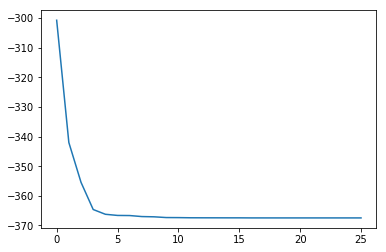

In [5]:
filename = hdf5_pe_output_file_hierarchical
with h5py.File(filename, 'r') as f:
    trajectory = f['/multistarts/0/iterCostFunCost'][:]
for start in range(trajectory.shape[0]):
    plt.plot(trajectory[start])    
trajectory

In [15]:
compareResults(hdf5_pe_output_file_hierarchical)

#  __Exp___ __Act___ __Err___ _RelErr___
0: 1.000000 0.946404 -0.053596 -0.053596
1: 0.500000 0.437507 -0.062493 -0.124986
2: 0.400000 0.465838 0.065838 0.164594
3: 2.000000 1.855323 -0.144677 -0.072339
4: 0.100000 0.065731 -0.034269 -0.342694
5: 2.000000 1.984290 -0.015710 -0.007855
6: 3.000000 3.032268 0.032268 0.010756
7: 0.200000 0.186232 -0.013768 -0.068838
8: 4.000000 4.021128 0.021128 0.005282
Status: 4
Cost: -367.443443 (expected: -0.000000)


In [24]:
list(model.getParameterNames())

['p1',
 'p2',
 'p3',
 'p4',
 'p5',
 'scaling_x1',
 'offset_x2',
 'observable_x1withsigma_sigma']

In [8]:
!rm simh.h5
!{example_binary_dir}/example_steadystate_multi_simulator {hdf5_pe_output_file_hierarchical} / simh.h5 / --at-optimum

Running for start 0
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma


In [9]:
with h5py.File('simh.h5', 'r') as f:
    ysim = f['/multistarts/0/ySim'][:]
    ymes = f['/multistarts/0/yMes'][:]
print(ysim.shape)
print(ymes.shape)

(4, 20, 6)
(4, 20, 6)


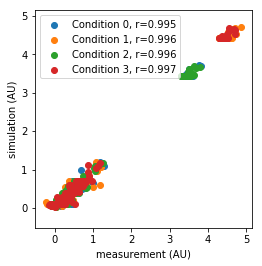

In [10]:
parpe.plotting.plotCorrelation(ymes, ysim)

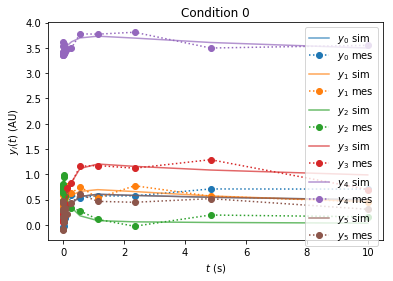

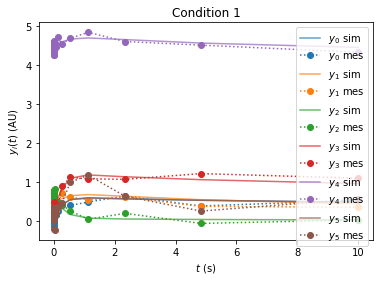

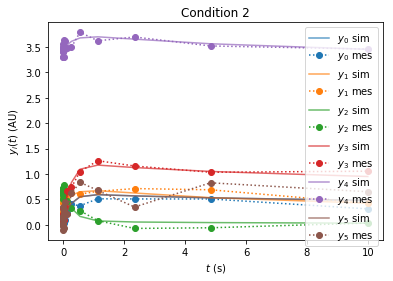

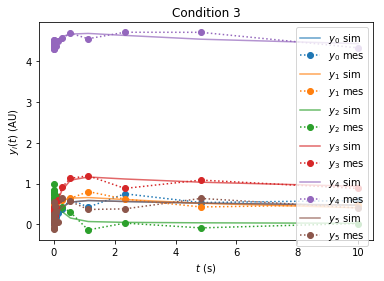

In [17]:
parpe.plotting.plotTrajectoryFits(ymes, ysim, timepoints)

## Ceres

In [25]:
example_data_ceres = f'{example_data_dir}/example_data_ceres.h5'
!cp {example_data_dir}/example_data.h5 {example_data_ceres}
!{optimizationOptionsPy} {example_data_ceres} -s optimizer 1
!PARPE_NO_DEBUG=1 mpiexec -n 4 {example_binary_dir}/example_steadystate_multi  -o deletemeceres/ {example_data_ceres}


[2019-01-13 18:46:29] [DBG] [1/dweindl] Rank 1/4 running on dweindl.
[2019-01-13 18:46:29] [DBG] [2/dweindl] Rank 2/4 running on dweindl.
[2019-01-13 18:46:29] [DBG] [1/dweindl] Seeding RNG with 1547401589
[2019-01-13 18:46:29] [DBG] [2/dweindl] Seeding RNG with 1547401589
[2019-01-13 18:46:29] [DBG] [3/dweindl] Rank 3/4 running on dweindl.
[2019-01-13 18:46:29] [DBG] [3/dweindl] Seeding RNG with 1547401589
[2019-01-13 18:46:29] [INF] [0/dweindl] Running with 4 MPI processes.
[2019-01-13 18:46:29] [DBG] [0/dweindl] Rank 0/4 running on dweindl.
[2019-01-13 18:46:29] [DBG] [0/dweindl] Seeding RNG with 1547401589
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 propo

[2019-01-13 18:46:30] [DBG] [1/dweindl] Message received after waiting 0.011418s.
[2019-01-13 18:46:30] [DBG] [1/dweindl] [o0i3c0] Result for 26: -9186.04 (0) (0.0012s-)
[2019-01-13 18:46:30] [DBG] [1/dweindl] [o0i3c1] Result for 26: -16345.6 (0) (0.0012s-)
[2019-01-13 18:46:30] [DBG] [1/dweindl] [o0i3c2] Result for 26: -9208.22 (0) (0.0016s-)
[2019-01-13 18:46:30] [DBG] [1/dweindl] [o0i3c3] Result for 26: -16002.8 (0) (0.0020s-)
[2019-01-13 18:46:30] [DBG] [2/dweindl] Message received after waiting 0.030069s.
[2019-01-13 18:46:30] [DBG] [1/dweindl] Message received after waiting 0.000007s.
[2019-01-13 18:46:30] [DBG] [3/dweindl] Message received after waiting 0.056819s.
[2019-01-13 18:46:30] [DBG] [2/dweindl] [o0i3c1] Result for 28: 77.5977 (0) (0.0277s+)
[2019-01-13 18:46:30] [DBG] [3/dweindl] [o0i3c2] Result for 29: 99.0149 (0) (0.0346s+)
[2019-01-13 18:46:30] [DBG] [1/dweindl] [o0i3c0] Result for 27: 90.154 (0) (0.0362s+)
[2019-01-13 18:46:30] [DBG] [2/dweindl] Message received aft

[2019-01-13 18:46:30] [DBG] [3/dweindl] [o0i7c3] Result for 55: 94.8456 (0) (0.0278s+)
[2019-01-13 18:46:30] [INF] [0/dweindl] [o0i7] iter: 7 cost: -366.65 time_iter: wall: 0.0839388s cpu: 0.196758s time_optim: wall: 1.01765s cpu: 2.3174s
callbacks.cc:105    7: f:-3.666500e+02 d: 2.69e+00 g: 3.61e+01 h: 1.55e-01 s: 4.59e-01 e:  1 it: 8.32e-02 tt: 1.02e+00
[2019-01-13 18:46:30] [DBG] [3/dweindl] Message received after waiting 0.012530s.
[2019-01-13 18:46:30] [DBG] [3/dweindl] [o0i8c0] Result for 56: -9210.23 (0) (0.0013s-)
[2019-01-13 18:46:30] [DBG] [3/dweindl] [o0i8c1] Result for 56: -16368.8 (0) (0.0016s-)
[2019-01-13 18:46:30] [DBG] [3/dweindl] [o0i8c2] Result for 56: -9224.4 (0) (0.0014s-)
[2019-01-13 18:46:30] [DBG] [3/dweindl] [o0i8c3] Result for 56: -16022.9 (0) (0.0013s-)
[2019-01-13 18:46:30] [DBG] [3/dweindl] Message received after waiting 0.000922s.
[2019-01-13 18:46:30] [DBG] [1/dweindl] Message received after waiting 0.049721s.
[2019-01-13 18:46:30] [DBG] [2/dweindl] Messa

[2019-01-13 18:46:31] [DBG] [2/dweindl] [o0i13c1] Result for 83: 80.5226 (0) (0.0284s+)
[2019-01-13 18:46:31] [DBG] [1/dweindl] [o0i13c0] Result for 82: 88.9068 (0) (0.0390s+)
[2019-01-13 18:46:31] [DBG] [3/dweindl] [o0i13c3] Result for 85: 94.8921 (0) (0.0269s+)
callbacks.cc:105   13: f:-3.674434e+02 d: 5.65e-06 g: 6.85e-03 h: 5.07e-04 s: 1.00e+00 e:  1 it: 8.68e-02 tt: 1.61e+00
[2019-01-13 18:46:31] [INF] [0/dweindl] [o0i13] iter: 13 cost: -367.443 time_iter: wall: 0.0875038s cpu: 0.196704s time_optim: wall: 1.60869s cpu: 3.55688s
[2019-01-13 18:46:31] [DBG] [1/dweindl] Message received after waiting 0.017189s.
[2019-01-13 18:46:31] [DBG] [1/dweindl] [o0i14c0] Result for 86: -9211.95 (0) (0.0013s-)
[2019-01-13 18:46:31] [DBG] [1/dweindl] [o0i14c1] Result for 86: -16370.9 (0) (0.0013s-)
[2019-01-13 18:46:31] [DBG] [1/dweindl] [o0i14c2] Result for 86: -9226.01 (0) (0.0015s-)
[2019-01-13 18:46:31] [DBG] [1/dweindl] [o0i14c3] Result for 86: -16025 (0) (0.0014s-)
[2019-01-13 18:46:31] [DB

line_search.cc:758 Line search failed: Wolfe zoom bracket width: 0.00000e+00 too small with descent_direction_max_norm: 1.41711e-09.
[2019-01-13 18:46:31] [INF] [0/dweindl] [o0i18] Optimizer status 0, final llh: -3.674434e+02, time: wall: 2.107171 cpu: 4.636552.
line_search_minimizer.cc:413 Terminating: Parameter tolerance reached. Relative step_norm: 0.000000e+00 <= 1.000000e-08.
[2019-01-13 18:46:32] [DBG] [0/dweindl] Thread ms #0 finished successfully
[2019-01-13 18:46:33] [DBG] [0/dweindl] runParallelMultiStartOptimization finished
[2019-01-13 18:46:33] [INF] [0/dweindl] Walltime on master: 4.215797s, CPU time of all processes: 10.353990s
[2019-01-13 18:46:33] [INF] [0/dweindl] Sent termination signal to workers.


In [18]:
compareResults('deletemeceres/_rank00000.h5')

#  __Exp___ __Act___ __Err___ _RelErr___
0: 1.000000 0.946404 -0.053596 -0.053596
1: 0.500000 0.437507 -0.062493 -0.124985
2: 0.400000 0.465838 0.065838 0.164594
3: 2.000000 1.855323 -0.144677 -0.072339
4: 0.100000 0.065731 -0.034269 -0.342694
5: 2.000000 1.984290 -0.015710 -0.007855
6: 3.000000 3.032268 0.032268 0.010756
7: 0.200000 0.186232 -0.013768 -0.068838
8: 4.000000 4.021128 0.021128 0.005282
Status: 0
Cost: -367.443443 (expected: -0.000000)


## Minibatch optimization

In [20]:
hdf5FileMinibatch = f'{example_data_dir}/example_data_minibatch.h5'

!{optimizationOptionsPy} {hdf5FileMinibatch} -s numStarts 1
!{optimizationOptionsPy} {hdf5FileMinibatch} -s hierarchicalOptimization 0
!{optimizationOptionsPy} {hdf5FileMinibatch} -s retryOptimization 0
!{optimizationOptionsPy} {hdf5FileMinibatch} -s optimizer 10 # minibatch
!{optimizationOptionsPy} {hdf5FileMinibatch} -s minibatch/maxEpochs 50
!{optimizationOptionsPy} {hdf5FileMinibatch} -s minibatch/batchSize 2
!{optimizationOptionsPy} {hdf5FileMinibatch} -s minibatch/parameterUpdater Vanilla
!{optimizationOptionsPy} {hdf5FileMinibatch} -s minibatch/Vanilla-learningRate 1e-5
!{optimizationOptionsPy} {hdf5FileMinibatch}

                hierarchicalOptimization            0
                               numStarts            1
                               optimizer           10
                       retryOptimization            0
                ceres/max_num_iterations          100
                         fmincon/GradObj        b'on'
                     fmincon/MaxFunEvals   10000000.0
                         fmincon/MaxIter          100
                          fmincon/TolFun            0
                            fmincon/TolX        1e-08
                       fmincon/algorithm b'interior-point'
                         fmincon/display      b'iter'
                   ipopt/acceptable_iter            1
         ipopt/acceptable_obj_change_tol        1e-12
                    ipopt/acceptable_tol        1e+20
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                          ipopt/max_iter          100
                  

In [21]:
!{parpe_source_root}/misc/selectStartingPoints.py {hdf5FileMinibatch} 9 # select starting point

Starting point backup exists in /optimizationOptions/randomStartsBackup
Selecting starting points [9]


In [23]:
!PARPE_MAX_SIMULATIONS_PER_PACKAGE=1 PARPE_NO_DEBUG=1 mpiexec -np 4 {example_binary_dir}/example_steadystate_multi -o deleteme-minibatch/ {hdf5FileMinibatch}

[2019-01-13 19:09:19] [INF] [0/dweindl] Running with 4 MPI processes.
[2019-01-13 19:09:19] [INF] [0/dweindl] Reading random initial theta 0 from /optimizationOptions/randomStarts
[2019-01-13 19:09:19] [INF] [0/dweindl] [o0e0b0] iter: 0 cost: 213.861 time_iter: wall: 0.0608471s cpu: 0.0661133s time_optim: wall: 0.0608478s cpu: 0.0661133s
[2019-01-13 19:09:19] [INF] [0/dweindl] [o0e0b1] iter: 1 cost: 191.977 time_iter: wall: 0.0564952s cpu: 0.054311s time_optim: wall: 0.117344s cpu: 0.120424s
[2019-01-13 19:09:19] [INF] [0/dweindl] [o0e1b0] iter: 2 cost: 266.906 time_iter: wall: 0.0405812s cpu: 0.041602s time_optim: wall: 0.157925s cpu: 0.162026s
[2019-01-13 19:09:19] [INF] [0/dweindl] [o0e1b1] iter: 3 cost: 103.155 time_iter: wall: 0.0435842s cpu: 0.0377072s time_optim: wall: 0.20151s cpu: 0.199733s
[2019-01-13 19:09:19] [INF] [0/dweindl] [o0e2b0] iter: 4 cost: 168.711 time_iter: wall: 0.0498205s cpu: 0.0454325s time_optim: wall: 0.251331s cpu: 0.245166s
[2019-01-13 19:09:19] [INF] [0/

[2019-01-13 19:09:22] [INF] [0/dweindl] [o0e24b0] iter: 48 cost: 27.9629 time_iter: wall: 0.0632233s cpu: 0.0926555s time_optim: wall: 2.5545s cpu: 2.5408s
[2019-01-13 19:09:22] [INF] [0/dweindl] [o0e24b1] iter: 49 cost: 32.3981 time_iter: wall: 0.0642105s cpu: 0.0894684s time_optim: wall: 2.61871s cpu: 2.63027s
[2019-01-13 19:09:22] [INF] [0/dweindl] [o0e25b0] iter: 50 cost: 4.12492 time_iter: wall: 0.0427278s cpu: 0.058824s time_optim: wall: 2.66144s cpu: 2.68909s
[2019-01-13 19:09:22] [INF] [0/dweindl] [o0e25b1] iter: 51 cost: 50.5988 time_iter: wall: 0.0450129s cpu: 0.0308687s time_optim: wall: 2.70646s cpu: 2.71996s
[2019-01-13 19:09:22] [INF] [0/dweindl] [o0e26b0] iter: 52 cost: 46.696 time_iter: wall: 0.0442642s cpu: 0.0299816s time_optim: wall: 2.75072s cpu: 2.74994s
[2019-01-13 19:09:22] [INF] [0/dweindl] [o0e26b1] iter: 53 cost: 1.51407 time_iter: wall: 0.0679217s cpu: 0.047819s time_optim: wall: 2.81864s cpu: 2.79776s
[2019-01-13 19:09:22] [INF] [0/dweindl] [o0e27b0] iter: 5

[2019-01-13 19:09:24] [INF] [0/dweindl] [o0e49b0] iter: 98 cost: -32.3662 time_iter: wall: 0.0562165s cpu: 0.0528369s time_optim: wall: 4.86588s cpu: 4.845s
[2019-01-13 19:09:24] [INF] [0/dweindl] [o0e49b1] iter: 99 cost: -21.3099 time_iter: wall: 0.0528483s cpu: 0.061559s time_optim: wall: 4.91873s cpu: 4.90656s
[2019-01-13 19:09:24] [INF] [0/dweindl] [o0] Number of epochs exceeded.
[2019-01-13 19:09:24] [INF] [0/dweindl] [o0i100] Optimizer status 1, final llh: -2.130994e+01, time: wall: 4.919899 cpu: 4.906559.
[2019-01-13 19:09:25] [INF] [0/dweindl] Walltime on master: 6.231866s, CPU time of all processes: 14.689058s
[2019-01-13 19:09:25] [INF] [0/dweindl] Sent termination signal to workers.


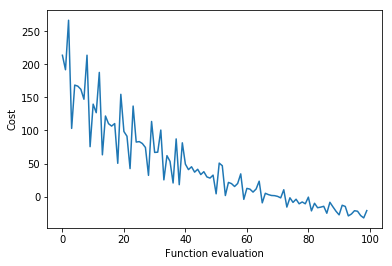

In [25]:
filename = 'deleteme-minibatch/_rank00000.h5'
with h5py.File(filename, 'r') as f:
    trajectory = f['/multistarts/0/iterCostFunCost'][:]
for start in range(trajectory.shape[0]):
    plt.plot(trajectory[start])
    plt.gca().set_xlabel("Function evaluation")
    plt.gca().set_ylabel("Cost")
#trajectory

### Compare learning rates

In [24]:
learningRates = np.logspace(0, -5, 6)
for i, learningRate in enumerate(learningRates):
    curInputFile = "example-data-minibatch-rate-%d.h5" % i
    outprefix = "deleteme-minibatch-rate-%d/" % i
    !cp {hdf5FileMinibatch} {curInputFile}
    !{optimizationOptionsPy} {curInputFile} -s minibatch/Vanilla-learningRate learningRate
    !PARPE_MAX_SIMULATIONS_PER_PACKAGE=1 PARPE_NO_DEBUG=1 mpiexec -np 4 {example_binary_dir}/example_steadystate_multi -o {outprefix} {hdf5FileMinibatch}

[2019-01-13 19:09:35] [INF] [0/dweindl] Running with 4 MPI processes.
[2019-01-13 19:09:35] [INF] [0/dweindl] Reading random initial theta 0 from /optimizationOptions/randomStarts
[2019-01-13 19:09:35] [INF] [0/dweindl] [o0e0b0] iter: 0 cost: 205.667 time_iter: wall: 0.047628s cpu: 0.0540632s time_optim: wall: 0.0476284s cpu: 0.0540632s
[2019-01-13 19:09:35] [INF] [0/dweindl] [o0e0b1] iter: 1 cost: 200.132 time_iter: wall: 0.0418043s cpu: 0.040731s time_optim: wall: 0.0894331s cpu: 0.0947942s
[2019-01-13 19:09:35] [INF] [0/dweindl] [o0e1b0] iter: 2 cost: 182.758 time_iter: wall: 0.042911s cpu: 0.056552s time_optim: wall: 0.132344s cpu: 0.151346s
[2019-01-13 19:09:35] [INF] [0/dweindl] [o0e1b1] iter: 3 cost: 184.379 time_iter: wall: 0.0516896s cpu: 0.0595717s time_optim: wall: 0.184034s cpu: 0.210918s
[2019-01-13 19:09:35] [INF] [0/dweindl] [o0e2b0] iter: 4 cost: 176.246 time_iter: wall: 0.0365075s cpu: 0.0464303s time_optim: wall: 0.220542s cpu: 0.257348s
[2019-01-13 19:09:35] [INF] [0

[2019-01-13 19:09:37] [INF] [0/dweindl] [o0e24b0] iter: 48 cost: 55.8934 time_iter: wall: 0.0487931s cpu: 0.0441571s time_optim: wall: 2.23701s cpu: 2.13775s
[2019-01-13 19:09:37] [INF] [0/dweindl] [o0e24b1] iter: 49 cost: 5.67469 time_iter: wall: 0.0482205s cpu: 0.0640633s time_optim: wall: 2.28523s cpu: 2.20181s
[2019-01-13 19:09:37] [INF] [0/dweindl] [o0e25b0] iter: 50 cost: 24.6401 time_iter: wall: 0.0455727s cpu: 0.0414979s time_optim: wall: 2.3308s cpu: 2.24331s
[2019-01-13 19:09:37] [INF] [0/dweindl] [o0e25b1] iter: 51 cost: 29.1076 time_iter: wall: 0.0501155s cpu: 0.0441533s time_optim: wall: 2.38092s cpu: 2.28747s
[2019-01-13 19:09:37] [INF] [0/dweindl] [o0e26b0] iter: 52 cost: 27.4642 time_iter: wall: 0.0476111s cpu: 0.0449318s time_optim: wall: 2.42853s cpu: 2.3324s
[2019-01-13 19:09:37] [INF] [0/dweindl] [o0e26b1] iter: 53 cost: 19.8287 time_iter: wall: 0.0664347s cpu: 0.0555521s time_optim: wall: 2.49497s cpu: 2.38795s
[2019-01-13 19:09:37] [INF] [0/dweindl] [o0e27b0] iter

[2019-01-13 19:09:39] [INF] [0/dweindl] [o0e49b0] iter: 98 cost: -25.0325 time_iter: wall: 0.047267s cpu: 0.0459551s time_optim: wall: 4.40729s cpu: 4.22929s
[2019-01-13 19:09:39] [INF] [0/dweindl] [o0e49b1] iter: 99 cost: -28.9873 time_iter: wall: 0.0491199s cpu: 0.0472767s time_optim: wall: 4.45641s cpu: 4.27656s
[2019-01-13 19:09:39] [INF] [0/dweindl] [o0] Number of epochs exceeded.
[2019-01-13 19:09:39] [INF] [0/dweindl] [o0i100] Optimizer status 1, final llh: -2.898728e+01, time: wall: 4.457458 cpu: 4.276562.
[2019-01-13 19:09:41] [INF] [0/dweindl] Walltime on master: 6.222243s, CPU time of all processes: 15.659639s
[2019-01-13 19:09:41] [INF] [0/dweindl] Sent termination signal to workers.
[2019-01-13 19:09:41] [INF] [0/dweindl] Running with 4 MPI processes.
[2019-01-13 19:09:41] [INF] [0/dweindl] Reading random initial theta 0 from /optimizationOptions/randomStarts
[2019-01-13 19:09:42] [INF] [0/dweindl] [o0e0b0] iter: 0 cost: 125.071 time_iter: wall: 0.0549493s cpu: 0.0536825s 

[2019-01-13 19:09:43] [INF] [0/dweindl] [o0e22b0] iter: 44 cost: 41.247 time_iter: wall: 0.0444383s cpu: 0.0465169s time_optim: wall: 1.80525s cpu: 1.93642s
[2019-01-13 19:09:43] [INF] [0/dweindl] [o0e22b1] iter: 45 cost: 33.2439 time_iter: wall: 0.0528514s cpu: 0.0592053s time_optim: wall: 1.8581s cpu: 1.99563s
[2019-01-13 19:09:43] [INF] [0/dweindl] [o0e23b0] iter: 46 cost: 31.4422 time_iter: wall: 0.041835s cpu: 0.0527751s time_optim: wall: 1.89994s cpu: 2.0484s
[2019-01-13 19:09:43] [INF] [0/dweindl] [o0e23b1] iter: 47 cost: 35.8424 time_iter: wall: 0.0386209s cpu: 0.0390796s time_optim: wall: 1.93856s cpu: 2.08748s
[2019-01-13 19:09:43] [INF] [0/dweindl] [o0e24b0] iter: 48 cost: 30.5646 time_iter: wall: 0.03261s cpu: 0.0372786s time_optim: wall: 1.97117s cpu: 2.12476s
[2019-01-13 19:09:43] [INF] [0/dweindl] [o0e24b1] iter: 49 cost: 29.7657 time_iter: wall: 0.0384067s cpu: 0.0438682s time_optim: wall: 2.00958s cpu: 2.16863s
[2019-01-13 19:09:43] [INF] [0/dweindl] [o0e25b0] iter: 50

[2019-01-13 19:09:45] [INF] [0/dweindl] [o0e47b0] iter: 94 cost: -17.0446 time_iter: wall: 0.0484702s cpu: 0.0595532s time_optim: wall: 4.04507s cpu: 4.29276s
[2019-01-13 19:09:46] [INF] [0/dweindl] [o0e47b1] iter: 95 cost: -30.4721 time_iter: wall: 0.0475218s cpu: 0.0558633s time_optim: wall: 4.09259s cpu: 4.34863s
[2019-01-13 19:09:46] [INF] [0/dweindl] [o0e48b0] iter: 96 cost: -28.0442 time_iter: wall: 0.0474878s cpu: 0.0532268s time_optim: wall: 4.14008s cpu: 4.40185s
[2019-01-13 19:09:46] [INF] [0/dweindl] [o0e48b1] iter: 97 cost: -23.0114 time_iter: wall: 0.0463855s cpu: 0.0517646s time_optim: wall: 4.18647s cpu: 4.45362s
[2019-01-13 19:09:46] [INF] [0/dweindl] [o0e49b0] iter: 98 cost: -20.9759 time_iter: wall: 0.0470411s cpu: 0.0535481s time_optim: wall: 4.23351s cpu: 4.50717s
[2019-01-13 19:09:46] [INF] [0/dweindl] [o0e49b1] iter: 99 cost: -32.7045 time_iter: wall: 0.0449654s cpu: 0.0467584s time_optim: wall: 4.27847s cpu: 4.55392s
[2019-01-13 19:09:46] [INF] [0/dweindl] [o0] N

[2019-01-13 19:09:50] [INF] [0/dweindl] [o0e20b0] iter: 40 cost: 76.4062 time_iter: wall: 0.0610214s cpu: 0.0633809s time_optim: wall: 2.11444s cpu: 2.28438s
[2019-01-13 19:09:51] [INF] [0/dweindl] [o0e20b1] iter: 41 cost: 14.7753 time_iter: wall: 0.0564835s cpu: 0.0506767s time_optim: wall: 2.17093s cpu: 2.33506s
[2019-01-13 19:09:51] [INF] [0/dweindl] [o0e21b0] iter: 42 cost: 38.868 time_iter: wall: 0.0638225s cpu: 0.0411683s time_optim: wall: 2.23475s cpu: 2.37623s
[2019-01-13 19:09:51] [INF] [0/dweindl] [o0e21b1] iter: 43 cost: 43.1995 time_iter: wall: 0.0444075s cpu: 0.0534205s time_optim: wall: 2.27916s cpu: 2.42965s
[2019-01-13 19:09:51] [INF] [0/dweindl] [o0e22b0] iter: 44 cost: 35.106 time_iter: wall: 0.0404159s cpu: 0.0422759s time_optim: wall: 2.31957s cpu: 2.47193s
[2019-01-13 19:09:51] [INF] [0/dweindl] [o0e22b1] iter: 45 cost: 39.4713 time_iter: wall: 0.0583134s cpu: 0.0619917s time_optim: wall: 2.37789s cpu: 2.53392s
[2019-01-13 19:09:51] [INF] [0/dweindl] [o0e23b0] iter

[2019-01-13 19:09:53] [INF] [0/dweindl] [o0e45b0] iter: 90 cost: -21.6215 time_iter: wall: 0.0457056s cpu: 0.045995s time_optim: wall: 4.46406s cpu: 4.5627s
[2019-01-13 19:09:53] [INF] [0/dweindl] [o0e45b1] iter: 91 cost: -19.8002 time_iter: wall: 0.0408777s cpu: 0.0413135s time_optim: wall: 4.50494s cpu: 4.60402s
[2019-01-13 19:09:53] [INF] [0/dweindl] [o0e46b0] iter: 92 cost: -24.8598 time_iter: wall: 0.0355912s cpu: 0.0335291s time_optim: wall: 4.54053s cpu: 4.63755s
[2019-01-13 19:09:53] [INF] [0/dweindl] [o0e46b1] iter: 93 cost: -19.8593 time_iter: wall: 0.0466139s cpu: 0.0439267s time_optim: wall: 4.58715s cpu: 4.68147s
[2019-01-13 19:09:53] [INF] [0/dweindl] [o0e47b0] iter: 94 cost: -17.0301 time_iter: wall: 0.0510215s cpu: 0.0490426s time_optim: wall: 4.63817s cpu: 4.73052s
[2019-01-13 19:09:53] [INF] [0/dweindl] [o0e47b1] iter: 95 cost: -30.4732 time_iter: wall: 0.0441674s cpu: 0.0365104s time_optim: wall: 4.68234s cpu: 4.76703s
[2019-01-13 19:09:53] [INF] [0/dweindl] [o0e48b0

[2019-01-13 19:09:57] [INF] [0/dweindl] [o0e18b1] iter: 37 cost: 87.2961 time_iter: wall: 0.0571384s cpu: 0.0538272s time_optim: wall: 1.80214s cpu: 1.75538s
[2019-01-13 19:09:57] [INF] [0/dweindl] [o0e19b0] iter: 38 cost: 50.9765 time_iter: wall: 0.0451324s cpu: 0.0316907s time_optim: wall: 1.84728s cpu: 1.78707s
[2019-01-13 19:09:57] [INF] [0/dweindl] [o0e19b1] iter: 39 cost: 46.979 time_iter: wall: 0.0428618s cpu: 0.04874s time_optim: wall: 1.89014s cpu: 1.83581s
[2019-01-13 19:09:57] [INF] [0/dweindl] [o0e20b0] iter: 40 cost: 46.7795 time_iter: wall: 0.0329752s cpu: 0.0382182s time_optim: wall: 1.92312s cpu: 1.87403s
[2019-01-13 19:09:57] [INF] [0/dweindl] [o0e20b1] iter: 41 cost: 43.077 time_iter: wall: 0.058227s cpu: 0.029179s time_optim: wall: 1.98134s cpu: 1.90321s
[2019-01-13 19:09:57] [INF] [0/dweindl] [o0e21b0] iter: 42 cost: 41.2305 time_iter: wall: 0.0377192s cpu: 0.0292093s time_optim: wall: 2.01906s cpu: 1.93242s
[2019-01-13 19:09:57] [INF] [0/dweindl] [o0e21b1] iter: 43

[2019-01-13 19:10:00] [INF] [0/dweindl] [o0e43b1] iter: 87 cost: -18.862 time_iter: wall: 0.0629897s cpu: 0.0795613s time_optim: wall: 4.38934s cpu: 4.39668s
[2019-01-13 19:10:00] [INF] [0/dweindl] [o0e44b0] iter: 88 cost: -15.6605 time_iter: wall: 0.0467878s cpu: 0.0622911s time_optim: wall: 4.43613s cpu: 4.45897s
[2019-01-13 19:10:00] [INF] [0/dweindl] [o0e44b1] iter: 89 cost: -22.3278 time_iter: wall: 0.0548083s cpu: 0.0557712s time_optim: wall: 4.49094s cpu: 4.51474s
[2019-01-13 19:10:00] [INF] [0/dweindl] [o0e45b0] iter: 90 cost: -27.7602 time_iter: wall: 0.0500239s cpu: 0.0479482s time_optim: wall: 4.54096s cpu: 4.56269s
[2019-01-13 19:10:00] [INF] [0/dweindl] [o0e45b1] iter: 91 cost: -13.1832 time_iter: wall: 0.0623764s cpu: 0.0595587s time_optim: wall: 4.60334s cpu: 4.62225s
[2019-01-13 19:10:00] [INF] [0/dweindl] [o0e46b0] iter: 92 cost: -19.0607 time_iter: wall: 0.0510473s cpu: 0.0575853s time_optim: wall: 4.65439s cpu: 4.67983s
[2019-01-13 19:10:00] [INF] [0/dweindl] [o0e46b

[2019-01-13 19:10:06] [INF] [0/dweindl] [o0e17b0] iter: 34 cost: 61.9158 time_iter: wall: 0.041993s cpu: 0.0383141s time_optim: wall: 2.22481s cpu: 2.19569s
[2019-01-13 19:10:06] [INF] [0/dweindl] [o0e17b1] iter: 35 cost: 53.266 time_iter: wall: 0.0666184s cpu: 0.0596387s time_optim: wall: 2.29143s cpu: 2.25532s
[2019-01-13 19:10:06] [INF] [0/dweindl] [o0e18b0] iter: 36 cost: 53.1847 time_iter: wall: 0.051898s cpu: 0.042345s time_optim: wall: 2.34333s cpu: 2.29767s
[2019-01-13 19:10:06] [INF] [0/dweindl] [o0e18b1] iter: 37 cost: 53.1912 time_iter: wall: 0.0352826s cpu: 0.0423203s time_optim: wall: 2.37861s cpu: 2.33999s
[2019-01-13 19:10:06] [INF] [0/dweindl] [o0e19b0] iter: 38 cost: 46.8432 time_iter: wall: 0.0637567s cpu: 0.0552152s time_optim: wall: 2.44237s cpu: 2.39521s
[2019-01-13 19:10:06] [INF] [0/dweindl] [o0e19b1] iter: 39 cost: 51.1078 time_iter: wall: 0.0560223s cpu: 0.0498606s time_optim: wall: 2.49839s cpu: 2.44507s
[2019-01-13 19:10:06] [INF] [0/dweindl] [o0e20b0] iter: 

[2019-01-13 19:10:08] [INF] [0/dweindl] [o0e42b0] iter: 84 cost: -17.8773 time_iter: wall: 0.055086s cpu: 0.0640108s time_optim: wall: 4.42884s cpu: 4.40226s
[2019-01-13 19:10:08] [INF] [0/dweindl] [o0e42b1] iter: 85 cost: -12.9511 time_iter: wall: 0.0496269s cpu: 0.0656827s time_optim: wall: 4.47847s cpu: 4.46795s
[2019-01-13 19:10:08] [INF] [0/dweindl] [o0e43b0] iter: 86 cost: -25.2805 time_iter: wall: 0.0519968s cpu: 0.0499938s time_optim: wall: 4.53047s cpu: 4.51794s
[2019-01-13 19:10:08] [INF] [0/dweindl] [o0e43b1] iter: 87 cost: -8.68647 time_iter: wall: 0.0337092s cpu: 0.0355681s time_optim: wall: 4.56418s cpu: 4.55351s
[2019-01-13 19:10:08] [INF] [0/dweindl] [o0e44b0] iter: 88 cost: -10.6088 time_iter: wall: 0.0357129s cpu: 0.0353404s time_optim: wall: 4.59989s cpu: 4.58885s
[2019-01-13 19:10:08] [INF] [0/dweindl] [o0e44b1] iter: 89 cost: -26.9105 time_iter: wall: 0.0428199s cpu: 0.048801s time_optim: wall: 4.64271s cpu: 4.63765s
[2019-01-13 19:10:08] [INF] [0/dweindl] [o0e45b0

[2019-01-13 19:10:13] [INF] [0/dweindl] [o0e15b0] iter: 30 cost: 66.8168 time_iter: wall: 0.0482233s cpu: 0.0507461s time_optim: wall: 1.42635s cpu: 1.50173s
[2019-01-13 19:10:13] [INF] [0/dweindl] [o0e15b1] iter: 31 cost: 67.1985 time_iter: wall: 0.037552s cpu: 0.0320699s time_optim: wall: 1.46391s cpu: 1.5338s
[2019-01-13 19:10:13] [INF] [0/dweindl] [o0e16b0] iter: 32 cost: 62.0776 time_iter: wall: 0.027615s cpu: 0.027587s time_optim: wall: 1.49152s cpu: 1.56139s
[2019-01-13 19:10:13] [INF] [0/dweindl] [o0e16b1] iter: 33 cost: 62.339 time_iter: wall: 0.0488149s cpu: 0.046204s time_optim: wall: 1.54034s cpu: 1.60759s
[2019-01-13 19:10:13] [INF] [0/dweindl] [o0e17b0] iter: 34 cost: 94.2312 time_iter: wall: 0.0356311s cpu: 0.0420679s time_optim: wall: 1.57597s cpu: 1.64966s
[2019-01-13 19:10:13] [INF] [0/dweindl] [o0e17b1] iter: 35 cost: 22.4884 time_iter: wall: 0.0428311s cpu: 0.0386967s time_optim: wall: 1.6188s cpu: 1.68836s
[2019-01-13 19:10:13] [INF] [0/dweindl] [o0e18b0] iter: 36 

[2019-01-13 19:10:15] [INF] [0/dweindl] [o0e40b0] iter: 80 cost: -0.884497 time_iter: wall: 0.0495766s cpu: 0.0473532s time_optim: wall: 3.41877s cpu: 3.44786s
[2019-01-13 19:10:15] [INF] [0/dweindl] [o0e40b1] iter: 81 cost: -21.7073 time_iter: wall: 0.04933s cpu: 0.0573351s time_optim: wall: 3.4681s cpu: 3.5052s
[2019-01-13 19:10:15] [INF] [0/dweindl] [o0e41b0] iter: 82 cost: -10.1331 time_iter: wall: 0.0446428s cpu: 0.0525667s time_optim: wall: 3.51274s cpu: 3.55776s
[2019-01-13 19:10:15] [INF] [0/dweindl] [o0e41b1] iter: 83 cost: -16.9156 time_iter: wall: 0.0419386s cpu: 0.0473253s time_optim: wall: 3.55468s cpu: 3.60509s
[2019-01-13 19:10:15] [INF] [0/dweindl] [o0e42b0] iter: 84 cost: -23.9853 time_iter: wall: 0.0495271s cpu: 0.0438771s time_optim: wall: 3.60421s cpu: 3.64897s
[2019-01-13 19:10:15] [INF] [0/dweindl] [o0e42b1] iter: 85 cost: -6.29911 time_iter: wall: 0.048914s cpu: 0.0477435s time_optim: wall: 3.65312s cpu: 3.69671s
[2019-01-13 19:10:15] [INF] [0/dweindl] [o0e43b0] 

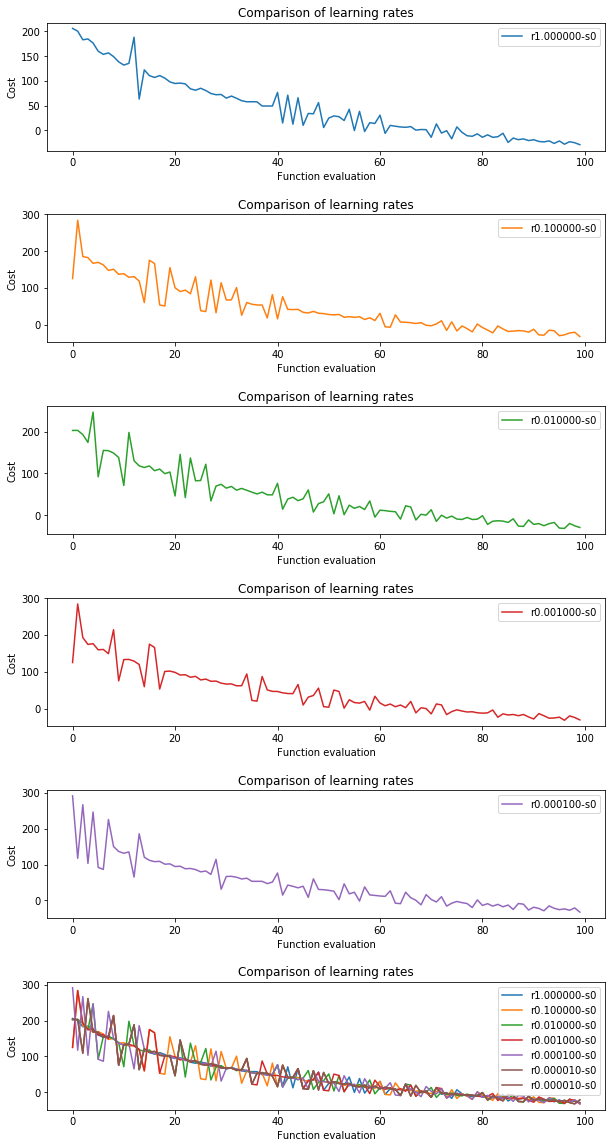

In [26]:
fig, axs = plt.subplots(nrows=len(learningRates + 1), figsize=(10, 20))
for i, learningRate in enumerate(learningRates):
    filename = "deleteme-minibatch-rate-%d/_rank00000.h5" % i
    with h5py.File(filename, 'r') as f:
        trajectory = f['/multistarts/0/iterCostFunCost'][:]
    for start in range(trajectory.shape[0]):
        for ax in (axs[i], axs[-1]):
            ax.plot(trajectory[start], label="r%f-s%d"%(learningRate, start), color="C%d"%i)
            ax.set_xlabel("Function evaluation")
            ax.set_ylabel("Cost")
            ax.set_title("Comparison of learning rates")
            ax.legend()
plt.subplots_adjust(hspace=0.5)

In [33]:
#?plt.subplots_adjust

# TODO

## preeequilibration
## different optimizers
## improve timing

In [34]:
list(model.getParameterNames())

['p1',
 'p2',
 'p3',
 'p4',
 'p5',
 'scaling_x1',
 'offset_x2',
 'observable_x1withsigma_sigma']